In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,ParameterGrid,cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from gensim.models import Word2Vec
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
import torch
from transformers import AutoTokenizer, AutoModel

d:\Anaconda\envs\doodlegen\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
d:\Anaconda\envs\doodlegen\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
d:\Anaconda\envs\doodlegen\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
lemmatizer = WordNetLemmatizer()

# Cleanup + Tokenization + Lemmatization 
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower().strip()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df = pd.read_csv('D:\\GDG_Hammad_ML\\dataset\\train.csv')
df['comment'] = df['comment'].apply(clean_text)
X = df['comment']
y = df['label']

In [3]:
class GridSearchCVWithProgress:
    def __init__(self, estimator, param_grid,X,y, scoring=None, cv=5, n_jobs=None):
        self.estimator = estimator
        self.param_grid = param_grid
        self.cv = cv
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.best_params_ = None
        self.best_score_ = -np.inf
        self.X = X
        self.y = y

    def fit(self):
        param_combinations = list(ParameterGrid(self.param_grid))
        
        # Initializing the progress bar
        with tqdm(total=len(param_combinations), desc="Grid Search Progress", unit="combination") as pbar:
            for params in param_combinations:
                self.estimator.set_params(**params)
                
                scores = cross_val_score(self.estimator, self.X, self.y, cv=self.cv, scoring=self.scoring, n_jobs=self.n_jobs)
                mean_score = np.mean(scores)
                
                # Save the vbest
                if mean_score > self.best_score_:
                    self.best_score_ = mean_score
                    self.best_params_ = params
                
                # INC pbar
                pbar.update(1)
        
        return self
    
    def predict(self,X_test):
        self.estimator.set_params(**self.best_params_)
        self.estimator.fit(self.X,self.y)
        y_pred = self.estimator.predict(X_test)
        return y_pred

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=420) 

In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("fine_tuned_muril_3")
model = AutoModel.from_pretrained("fine_tuned_muril_3").to(device)

def get_mean_embedding(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embedding.cpu().numpy()  


In [13]:
# Generate mean-pooled MuRIL embeddings for the training set
X_train_vect = np.array([get_mean_embedding(doc, tokenizer, model) for doc in X_train])
X_train_vect = normalize(X_train_vect, axis=1)

# Generate mean-pooled MuRIL embeddings for the test set
X_test_vect = np.array([get_mean_embedding(doc, tokenizer, model) for doc in X_test])
X_test_vect = normalize(X_test_vect, axis=1)


In [6]:
X_train_vectn = np.array([get_mean_embedding(doc, tokenizer, model) for doc in X_train])
X_test_vectn = np.array([get_mean_embedding(doc, tokenizer, model) for doc in X_test])

d:\Anaconda\envs\doodlegen\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [8]:
model = LinearSVC()

#'C': [0.001, 0.01,0.05, 0.1, 1, 10,],  
#'tol' : [1e-4,1e-3]  

param_grid = {
    'C': [0.15,0.05, 0.1,0.5, 1,],   
    'max_iter': [1000, 5000,2500],
    'tol' : [1e-4]  
}

In [ ]:
grid_search = GridSearchCVWithProgress(estimator=model, 
                           param_grid=param_grid, 
                           scoring='f1_macro', 
                           cv=5,
                           X = X_train_vect,
                           y = y_train,                  
                           )  

grid_search.fit()

print("Best parameters found: ", grid_search.best_params_)

Grid Search Progress:   0%|          | 0/15 [00:00<?, ?combination/s]

In [12]:
#MuRIL on its own...

best_model = LinearSVC(C=0.1,tol=0.0001)

def report(model):
    model.fit(X_train_vect,y_train)
    preds = model.predict(X_test_vect)
    print(classification_report(y_test,preds))
    ConfusionMatrixDisplay.from_predictions(y_test,preds)
    plt.show()


report(best_model)

NameError: name 'X_train_vect' is not defined

              precision    recall  f1-score   support

       doubt       0.82      0.76      0.79     16575
    feedback       0.76      0.83      0.80     28692
  irrelevant       0.79      0.72      0.75     18858

    accuracy                           0.78     64125
   macro avg       0.79      0.77      0.78     64125
weighted avg       0.78      0.78      0.78     64125



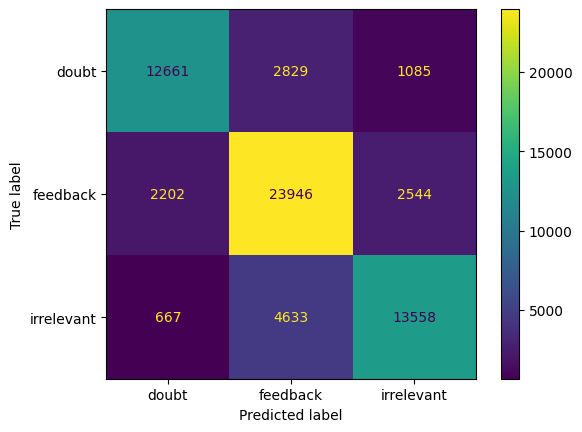

In [8]:
best_model = LinearSVC(C=3)  #c=3

def report(model):
    model.fit(X_train_vectn,y_train)
    preds = model.predict(X_test_vectn)
    print(classification_report(y_test,preds))
    ConfusionMatrixDisplay.from_predictions(y_test,preds)
    plt.show()


report(best_model)

In [16]:
df2 = pd.read_csv('D:\\GDG_Hammad_ML\\dataset\\test.csv')

df2['comment'] = df2['comment'].apply(clean_text)
X = df2['comment']

X_vect = np.array([get_mean_embedding(doc, tokenizer, model) for doc in X])
#X_vect = normalize(X_vect, axis=1)

best_model = LinearSVC(C=0.1)
best_model.fit(X_train_vectn,y_train)

preds = best_model.predict(X_vect)

# Create a solution DataFrame
sol = pd.DataFrame({'ID': df2['id'], 'Label': preds})

In [17]:
sol.to_csv('solutionFinalLone(c=0.1)No.csv',index=False)